# `hw2`: Modeling photovoltaic power production

In [1]:
# Fill in this cell with your personal details:
# - Name: Mvomo Eto Wilfried
# - Student ID: s226625
# - Email: Wilfried.MvomoEto@student.uliege.be

In this homework, you will have to build a simple probabilistic model of the production of the photovoltaic panels installed on the ULiège campus. You will use the data from the previous homework to fit the model parameters.

Deadline: **Monday, November 27**.

- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- Homeworks are carried out alone.

# Photovoltaic production model

In this homework, the production $P_{t}$ of the photovoltaic panels (when $\phi^s_{t} > 0.1$, see below) is assumed to follow the model

\begin{align}
    P_{1:T} &\sim \mathcal{N}(\eta A \frac{F_{1:T}}{\sin \phi^s_{1:T}} \cos(\alpha(\theta^s_{1:T}, \phi^s_{1:T}, \theta^p, \phi^p)), \sigma^2 1)
\end{align}

where the inputs are

- $F_{t} \in \mathbb{R}$ the horizontal irradiance forecast,
- $\theta_{t}^s \in \mathbb{R}$ the sun azimuth,
- $\phi_{t}^s \in \mathbb{R}$ the sun elevation (assumed greater than $0.1$),

the parameters are

- $\sigma^2 \in \mathbb{R}^+$ the variance of the power production,
- $\eta \in [0, 1]$ the panels efficiency coefficient,
- $\theta^p \in \mathbb{R}$ the azimuth of the normal of the panel,
- $\phi^p \in \mathbb{R}$ the elevation of the normal of the panel,

the constants are

- $A = 2600 \space \text{m}^2$ the area of photovoltaic panels,

and $\alpha(\theta^s_{t}, \phi^s_{t}, \theta^p, \phi^p)$ denotes the angle between the sun orientation $(\theta^s_{t}, \phi^s_{t})$ and the panel orientation $(\theta^p, \phi^p)$.

The data is extracted from Homework 1 by selecting the rows for which the sun elevation $\phi^s_{t}$ is above $0.1$ and is available in `data/power.csv`. The columns are defined as
- `irradiance`: the horizontal irradiance forecast $F_t$ (W / m2),
- `irradiance_top`: the solar irradiance forecast at the top of the atmosphere (W / m2),
- `power`: the power production of the photovoltaic panels $P_t$ (W),
- `sun_azimuth`: the azimuth of the sun $\theta^s_t$ (rad),
- `sun_elevation`: the elevation of the sun $\phi^s_t$ (rad).

<div class="alert alert-info">
    
**Information**. We provide the function `cosine_orentations` that takes as inputs the sun orientation $(\theta^s_{1:T}, \phi^s_{1:T})$ and the panel orientation $(\theta^p, \phi^p)$ and outputs the cosine $\cos(\alpha(\theta^s_{t}, \phi^s_{t}, \theta^p, \phi^p))$ of the angle between these orientations.
    
</div>

In [2]:
import pandas as pd
import emcee
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, norm, gamma 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize
from IPython.display import Image
import tqdm

In [3]:
data = pd.read_csv('./data/Power.csv')

In [4]:
data.head(3)

,datetime,irradiance,irradiance_top,power,sun_azimuth,sun_elevation
0,2022-01-01 08:45:00+00:00,23.47,99.59,31098.0,0.118582,2.441109
1,2022-01-01 09:00:00+00:00,46.19,169.79,35872.0,0.144492,2.495957
2,2022-01-01 09:15:00+00:00,67.58,217.01,38616.0,0.168565,2.551853


In [5]:
temp_values = data['sun_elevation'].copy()
data['sun_elevation'] = data['sun_azimuth']
data['sun_azimuth'] = temp_values
data.head(3)

,datetime,irradiance,irradiance_top,power,sun_azimuth,sun_elevation
0,2022-01-01 08:45:00+00:00,23.47,99.59,31098.0,2.441109,0.118582
1,2022-01-01 09:00:00+00:00,46.19,169.79,35872.0,2.495957,0.144492
2,2022-01-01 09:15:00+00:00,67.58,217.01,38616.0,2.551853,0.168565


In [6]:
print((data['sun_elevation'] > 0.1).all())
data.head(3)

True


,datetime,irradiance,irradiance_top,power,sun_azimuth,sun_elevation
0,2022-01-01 08:45:00+00:00,23.47,99.59,31098.0,2.441109,0.118582
1,2022-01-01 09:00:00+00:00,46.19,169.79,35872.0,2.495957,0.144492
2,2022-01-01 09:15:00+00:00,67.58,217.01,38616.0,2.551853,0.168565


Checking whether there are the ouliers in the data set.

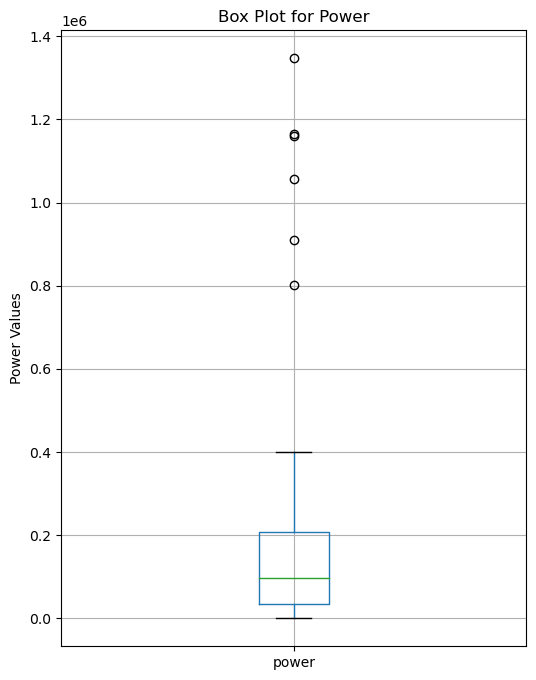

In [7]:
data[['power']].boxplot(figsize=(6, 8))
plt.title('Box Plot for Power')
plt.ylabel('Power Values')
plt.show()

The data set contains outliers. We will delete these out for the time being.

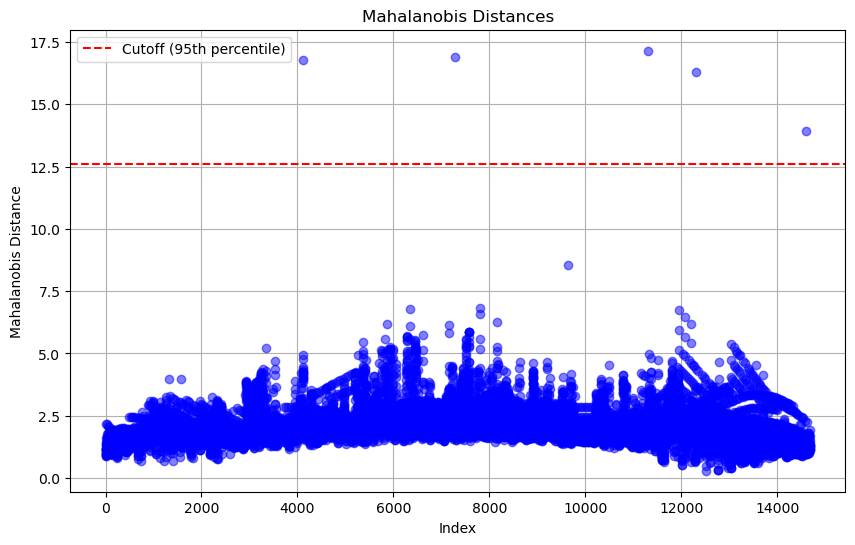

In [8]:
from scipy.spatial import distance
from scipy.stats import chi2

# Calculate the number of variables
num_variables = data.shape[1]

# Calculate the quantile corresponding to the 95th percentile of the chi-square distribution
quantile = chi2.ppf(0.95, num_variables)
# Calculate the mean vector
mean_vector = data[['irradiance', 'irradiance_top', 'power', 'sun_azimuth', 'sun_elevation']].mean()

# Calculate the covariance matrix
cov_matrix = data[['irradiance', 'irradiance_top', 'power', 'sun_azimuth', 'sun_elevation']].cov()

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculate Mahalanobis distance for each data point
mahalanobis_distances = []
for index, row in data.iterrows():
    data_point = row[['irradiance', 'irradiance_top', 'power', 'sun_azimuth', 'sun_elevation']]
    mahalanobis_distance = distance.mahalanobis(data_point, mean_vector, inv_cov_matrix)
    mahalanobis_distances.append(mahalanobis_distance)

# Add the Mahalanobis distances as a new column to your DataFrame
data['mahalanobis_distance'] = mahalanobis_distances

# Plot Mahalanobis distances
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['mahalanobis_distance'], marker='o', linestyle='', color='blue', alpha=0.5)
plt.axhline(y=quantile, color='red', linestyle='--', label='Cutoff (95th percentile)')
plt.title('Mahalanobis Distances')
plt.xlabel('Index')
plt.ylabel('Mahalanobis Distance')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Determine observations above cutoff
above_cutoff = data[data['mahalanobis_distance'] > quantile]
num_above_cutoff = len(above_cutoff)
print("Number of observations above cutoff:", num_above_cutoff)

# Delete observations above cutoff
data = data[data['mahalanobis_distance'] <= quantile]

Number of observations above cutoff: 5


In [10]:
def coordinates(theta, phi):
    x = np.cos(theta) * np.cos(phi)
    y = np.sin(theta) * np.cos(phi)
    z = np.sin(phi)
    return x, y, z

def cosine_orientations(theta_s, phi_s, theta_p, phi_p):
    xs, ys, zs = coordinates(theta_s, phi_s)
    xp, yp, zp = coordinates(theta_p, phi_p)
    return xs * xp + ys * yp + zs * zp

<div class="alert alert-success">
    
**Exercise**. Write a `simulate` function that takes inputs $(F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T})$ and parameters $(\sigma^2, \eta, \theta^p, \phi^p)$ as arguments and returns realizations of the power production $P_{1:T}$.

Tips: For numerical or practical reasons, you are free to choose alternative parametrizations for $(\sigma^2, \eta, \theta^p, \phi^p)$, as long as the original parameterization can be recovered.

</div>

In [11]:
# theta[0] = eta, theta[1] = theta_p, theta[2] = phi_p, theta[3] = sigma_2
def simulate(F_t, theta_s, phi_s, theta):
    if theta[0] < 0 or theta[0] > 1:
        print("eta must be in the range [0, 1]")
    else:
        cos_alpha = cosine_orientations(theta_s, phi_s, theta[1], theta[2])
        P_t = np.random.normal(2600 * F_t * theta[0] * (1 / np.sin(phi_s)) * cos_alpha, np.sqrt(theta[3]))

        return P_t

<div class="alert alert-success">
    
**Exercise**. Discuss the effects of each model parameter $\sigma^2$, $\eta$, $\theta^p$ and $\phi^p$. Make plots of random samples produced by the model above to illustrate those effects.
        
</div>

 As the values of $\sigma^2$ parameter increase, the probability density function of the distribution of power production changes less, and becomes more and more uniform.
 Regarding the effect of $\eta$ (efficiency of solar panels) and $\theta_p$, over the probability density function of the distribution of power production, the distribution remains unsteady because $\cos(\alpha(\theta^s_{t}, \phi^s_{t}, \theta^p, \phi^p))$ is in the range [-1;1], and $\eta$ is in the range [0;1] .
 The simulate function can be considered as a function $$ simulate_{\sigma^2,\eta,\theta_p,\phi_p}: \mathbb{R}^3 \rightarrow \mathbb{R} $$ $$(F_t, \theta^s_t, \phi^s_t) \rightarrow simulate_{\sigma^2,\eta,\theta_p,\phi_p}(F_t, \theta^s_t, \phi^s_t)$$.

a. Variying $\sigma^2$

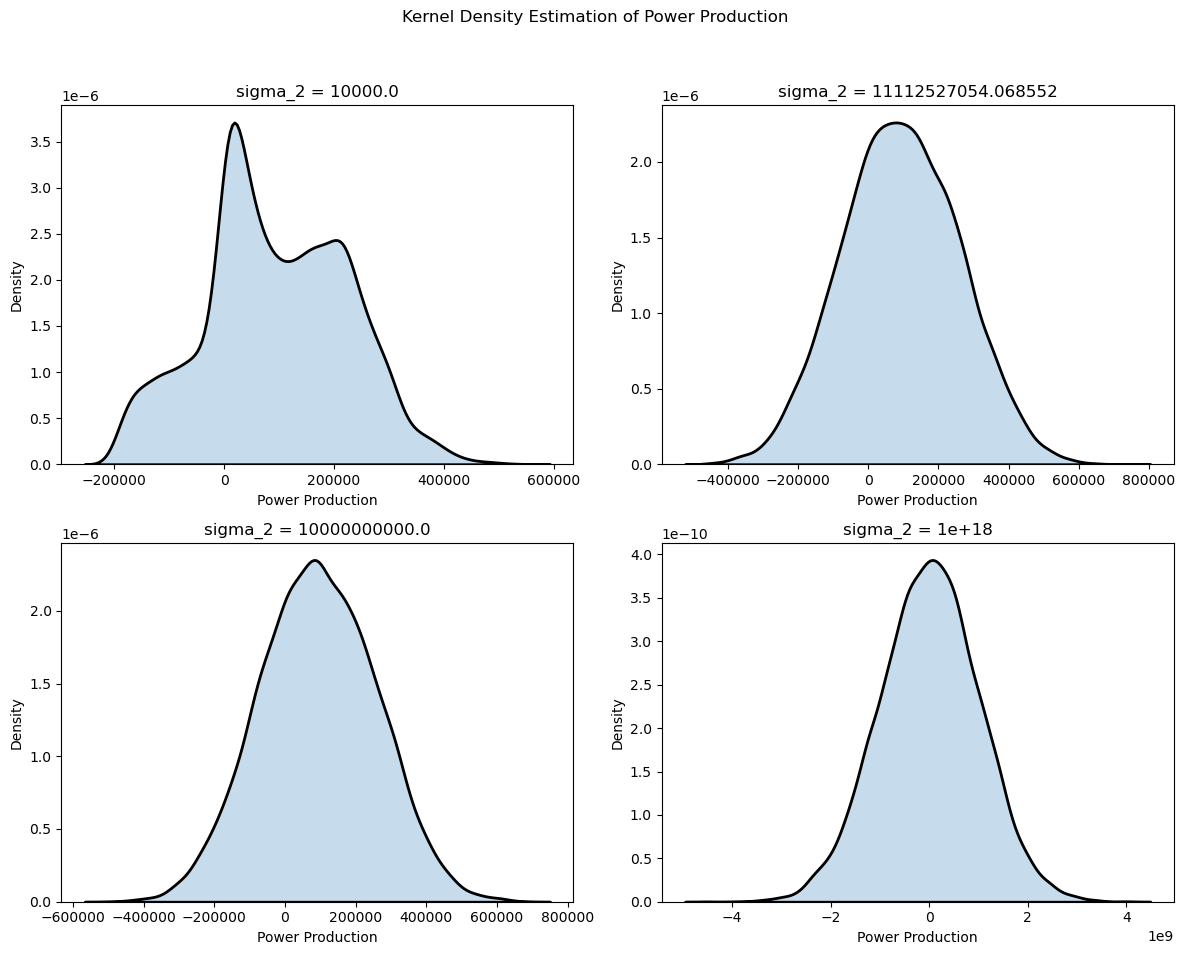

In [12]:
# Fix others parameters
theta_p = np.pi / 5
phi_p = -np.pi
eta = data['power'].sum() / (2600 * data['irradiance'].sum())

# Different values of sigma_2
sigma_2_values = [1e4, data['power'].std() ** 2, 1e10, 1e18]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Kernel Density Estimation of Power Production')

for i, sigma_2 in enumerate(sigma_2_values):
    production_values = np.zeros(data.shape[0])

    for j in range(data.shape[0]):
        # Fix: Pass theta as a list [eta, theta_p, phi_p, sigma_2]
        production_values[j] = simulate(data['irradiance'].iloc[j], data['sun_azimuth'].iloc[j], data['sun_elevation'].iloc[j], [eta, theta_p, phi_p, sigma_2])

    # Plot KDE of production_values for each sigma_2 in the grid
    row, col = divmod(i, 2)
    sns.kdeplot(production_values, fill=True, edgecolor='black', linewidth=2, ax=axes[row, col])
    axes[row, col].set_title(f'sigma_2 = {sigma_2}')
    axes[row, col].set_xlabel('Power Production')
    axes[row, col].set_ylabel('Density')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

When $\sigma^2$ parameter is too smaller than the empirical standard deviation of power production, the KDE of power distribution is unknown. As soon as its value is larger than the empirical standard deviation, we get the Gaussian distribution. The higher the value the $\sigma^2$ value, the smaller the density (e.g: when $\sigma^2 = 10^{18}$).

b. Varying $\eta$

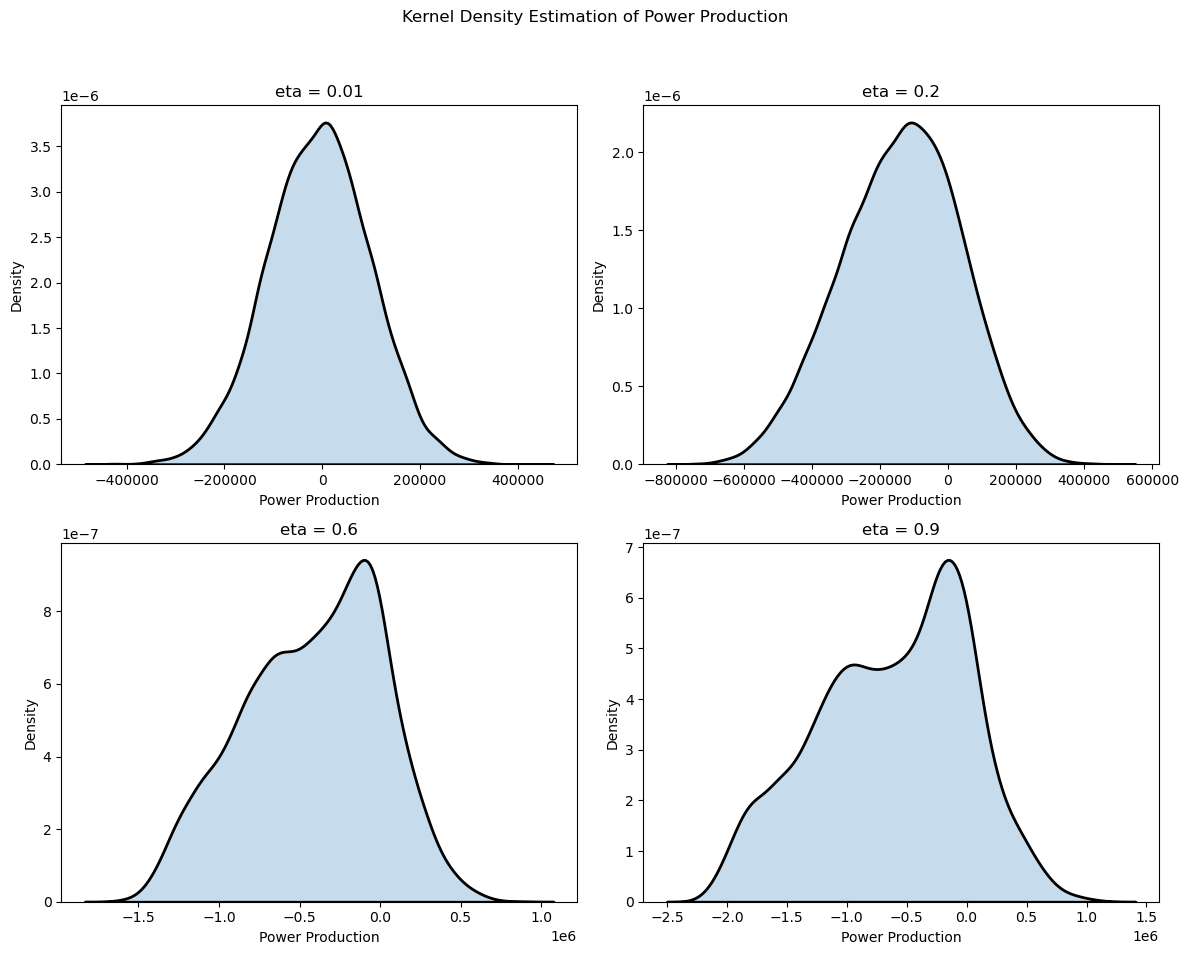

In [13]:
# Fix others parameters
theta_p = np.pi
phi_p = np.pi
sigma_2 = data['power'].std() ** 2

# Different values of eta
eta_values = [0.01, 0.2, 0.6, 0.9]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Kernel Density Estimation of Power Production')

for i, eta in enumerate(eta_values):
    production_values = np.zeros(data.shape[0])

    for j in range(data.shape[0]):
        # Fix: Pass theta as a list [eta, theta_p, phi_p, sigma_2]
        production_values[j] = simulate(data['irradiance'].iloc[j], data['sun_azimuth'].iloc[j], data['sun_elevation'].iloc[j], [eta, theta_p, phi_p, sigma_2])

    # Plot KDE of production_values for each eta in the grid
    row, col = divmod(i, 2)
    sns.kdeplot(production_values, fill=True, edgecolor='black', linewidth=2, ax=axes[row, col])
    axes[row, col].set_title(f'eta = {eta}')
    axes[row, col].set_xlabel('Power Production')
    axes[row, col].set_ylabel('Density')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

When $\eta$ is close to zero, the KDE of the power production resembles to a Gaussian distribution. But as soon as it greater than 0.5, its KDE becomes  completely unknown distribution. Also the power production values decrease slightly when $\eta$ tends towards 1.

c. Varying $\theta_p$

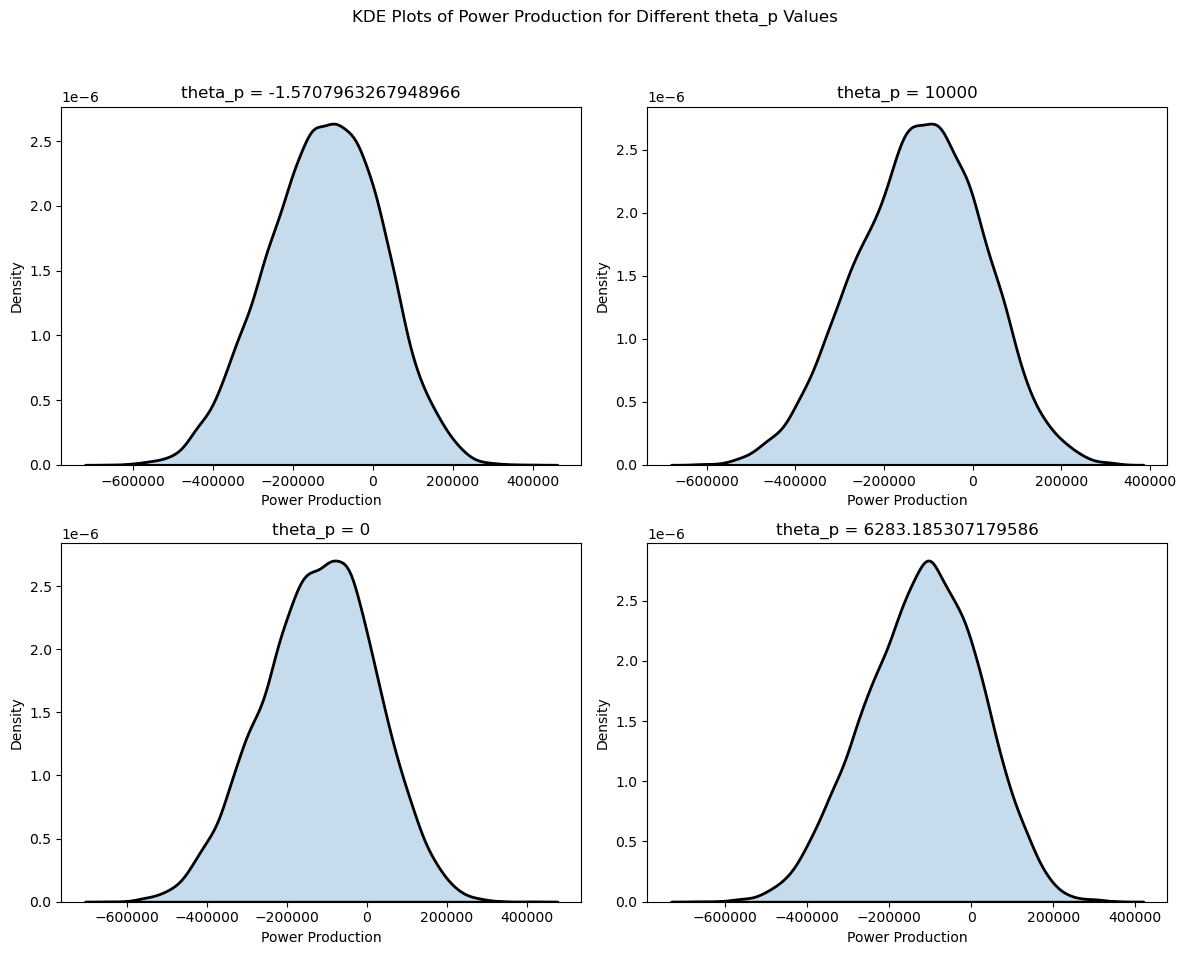

In [14]:
# Fix others parameters
phi_p = -np.pi / 2
sigma_2 = data['power'].std() ** 2

# Different values of theta_p
theta_p_values = [-np.pi / 2, 10000, 0, 2000 * np.pi]
eta = 0.14

# Create subplots for each theta_p
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('KDE Plots of Power Production for Different theta_p Values')

for i, theta_p in enumerate(theta_p_values):
    production_values = np.zeros(data.shape[0])

    # Calculate production_values for each theta_p
    for j in range(data.shape[0]):
        # Fix: Pass theta as a list [eta, theta_p, phi_p, sigma_2]
        production_values[j] = simulate(data['irradiance'].iloc[j], data['sun_azimuth'].iloc[j], data['sun_elevation'].iloc[j], [eta, theta_p, phi_p, sigma_2])

    # Plot KDE for each theta_p
    row, col = divmod(i, 2)
    sns.kdeplot(production_values, fill=True, edgecolor='black', linewidth=2, ax=axes[row, col])
    axes[row, col].set_title(f'theta_p = {theta_p}')
    axes[row, col].set_xlabel('Power Production')
    axes[row, col].set_ylabel('Density')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

As herementioned, the different values of $\theta_p$ has no real impact over the power distribution. We have always the Gaussian distribution in all cases.

d. Varying $\phi_p$

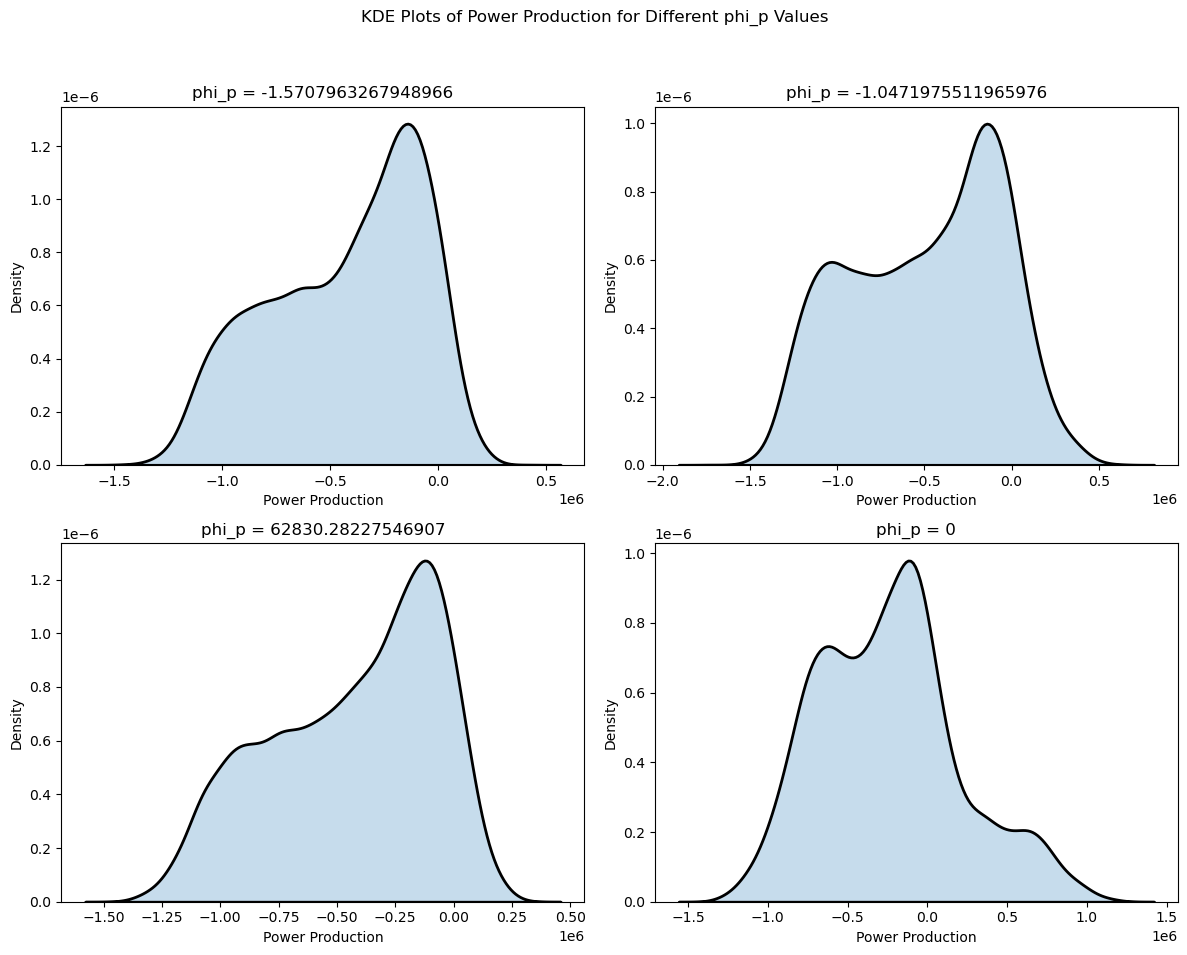

In [15]:
# Fix other parameters
theta_p = -np.pi / 5
sigma_2 = data['power'].std() ** 2
eta = 0.5  # Assuming some value for eta

# Different values of phi_p
phi_p_values = [-np.pi / 2, -np.pi / 3, (-np.pi / 2) + 10000 * 2 * np.pi, 0]

# Create subplots for each phi_p
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('KDE Plots of Power Production for Different phi_p Values')

for i, phi_p in enumerate(phi_p_values):
    production_values = np.zeros(data.shape[0])

    # Calculate production_values for each phi_p
    for j in range(data.shape[0]):
        # Fix: Pass theta as a list [eta, theta_p, phi_p, sigma_2]
        production_values[j] = simulate(data['irradiance'].iloc[j], data['sun_azimuth'].iloc[j], data['sun_elevation'].iloc[j], [eta, theta_p, phi_p, sigma_2])

    # Plot KDE for each phi_p
    row, col = divmod(i, 2)
    sns.kdeplot(production_values, fill=True, edgecolor='black', linewidth=2, ax=axes[row, col])
    axes[row, col].set_title(f'phi_p = {phi_p}')
    axes[row, col].set_xlabel('Power Production')
    axes[row, col].set_ylabel('Density')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

According to the different values of $\theta_p$ parameter, the KDE of the power
production are unknown in all plots.

# Fitting parameters

<div class="alert alert-success">
    
**Exercise**. Write a `log_likelihood` function that takes parameters $(\sigma^2, \eta, \theta^p, \phi^p)$ as arguments as well as realizations $P_{1:T}$ and their corresponding inputs $(F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T})$, and returns the log-likelihood $\log p(P_{1:T} \mid F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}, \sigma^2, \eta, \theta^p, \phi^p)$.
    
</div>

In [16]:
def log_likelihood(theta, F_t, theta_s, phi_s, P_t):
    cos_alpha = cosine_orientations(theta_s, phi_s, theta[1], theta[2])
    return norm.logpdf(P_t, loc= 2600 * theta[0] * F_t * (1 / np.sin(phi_s)) * cos_alpha, scale= np.sqrt(theta[3])).sum()

<div class="alert alert-success">
    
**Exercise**. Fit the parameters $(\sigma^2, \eta, \theta^p, \phi^p)$ by maximum likelihood estimation on the power production $P_{1:T}$ observed for inputs $(F_{1:T}, \phi^s_{1:T}, \alpha_{1:T})$ in the provided dataset.
    
Tips: Make sure to parameterize $(\sigma^2, \eta, \theta^p, \phi^p)$ properly such that their numerical values remain valid.
    
</div>

In [17]:
def neg_log_likelihood(theta, F_t, theta_s, phi_s, P_t):
    return -log_likelihood(theta, F_t, theta_s, phi_s, P_t)

# Fix initial values for each parameter
initial_params = [uniform(0, 1).rvs(), norm(0, np.pi).rvs(), norm(np.pi / 2, 1/8 * 1e-2).rvs() , data['power'].var()]

np.random.seed(0)
# Assuming you have data defined
result = minimize(neg_log_likelihood, initial_params, args=(data['irradiance'], data['sun_azimuth'], data['sun_elevation'], data['power']))
result

      fun: 185744.09801477188
 hess_inv: array([[ 1.23086143e-06, -2.93555308e-05,  8.63399798e-06,
        -3.10618823e-13],
       [-2.93555308e-05,  1.70436060e-03, -2.72915533e-04,
         4.57303607e-12],
       [ 8.63399798e-06, -2.72915533e-04,  1.25976728e-04,
        -4.23900747e-12],
       [-3.10618823e-13,  4.57303607e-12, -4.23900747e-12,
         1.00000000e+00]])
      jac: array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.3590234e-07])
  message: 'Optimization terminated successfully.'
     nfev: 140
      nit: 18
     njev: 28
   status: 0
  success: True
        x: array([1.27977116e-01, 2.52540330e+00, 1.37371793e+00, 1.11125271e+10])

<div class="alert alert-success">
    
**Exercise**. Plot the distribution of the photovoltaic production model using the maximum likelihood estimate of the parameters and compare it to the observed power production $P_{1:T}$.

</div>

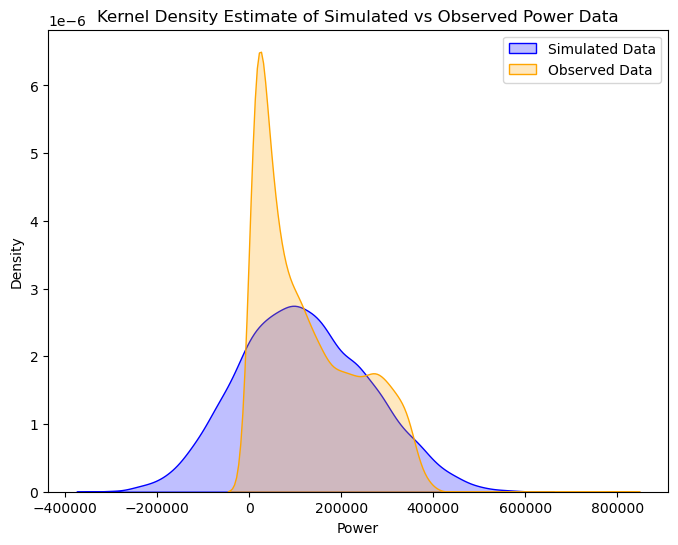

In [18]:
simulated_data = [simulate(data['irradiance'].iloc[i], data['sun_azimuth'].iloc[i], data['sun_elevation'].iloc[i], result.x) for i in range(len(data))]

# Plots KDE for simulated data and observed data
plt.figure(figsize=(8, 6))
sns.kdeplot(simulated_data, label='Simulated Data', color='blue', fill=True)
sns.kdeplot(data['power'], label='Observed Data', color='orange', fill=True)
plt.title('Kernel Density Estimate of Simulated vs Observed Power Data')
plt.xlabel('Power')
plt.ylabel('Density')
plt.legend()
plt.show()

Through the KDE, the distribution of the simulated data is more spread out than the one of observed data and does not reach the same maximum value as the observed data. It does not fit the observed data well.

# Bayesian model

We will now consider a complete Bayesian model where all parameters $(\sigma^2, \eta, \theta^p, \phi^p)$ are random variables with their own priors.

<div class="alert alert-success">
    
**Exercise**. Write the mathematical expression of the joint density $p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p | F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T})$.
    
</div>

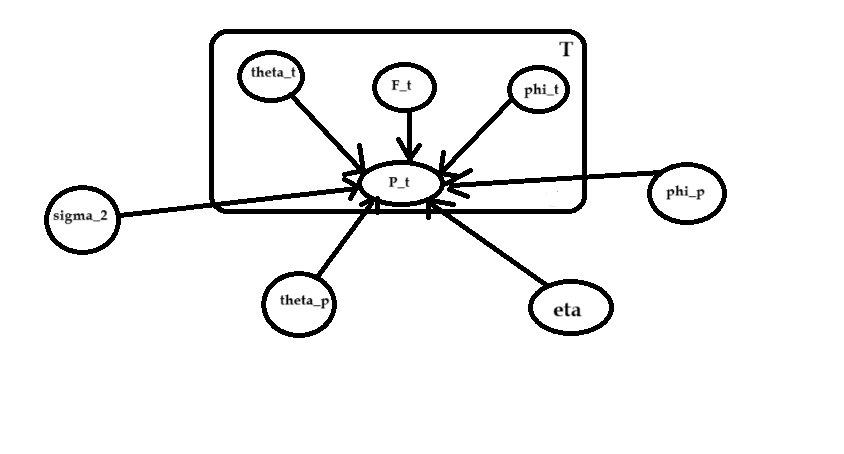

In [19]:
# Let's depict the Bayesian network for this situation
Image("./pic_bayesNet.png")

We have :

$$
   p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p , F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}) = p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p | F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}) \cdot p(\theta^s_{1:T}) \cdot p(F_{1:T}) \cdot p(\phi^s_{1:T})
$$
That implies : $$
p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p | F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}) = \frac{p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p , F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T})}{p(\theta^s_{1:T}) \cdot p(F_{1:T}) \cdot p(\phi^s_{1:T})}
$$
$$
p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p | F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}) = \frac{p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p , F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T})}{\prod_{t=1}^{T} p(\theta^s_t) \cdot p(F_t) \cdot p(\phi^s_t)}
$$

$$
p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p | F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}) = \frac{p(P_{1:T}, F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}| \sigma^2, \eta, \theta^p, \phi^p ) \cdot p(\sigma^2) \cdot p(\eta) \cdot p(\theta^p) \cdot p(\phi^p)}{\prod_{t=1}^{T} p(\theta^s_t) \cdot p(F_t) \cdot p(\phi^s_t)}
$$

$$
p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p | F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}) = \frac{p(\sigma^2) \cdot p(\eta) \cdot p(\theta^p) \cdot p(\phi^p) \cdot p(P_{1:T} | F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}, \sigma^2, \eta, \theta^p, \phi^p ) \cdot {\prod_{t=1}^{T} p(\theta^s_t) \cdot p(\phi^s_t) \cdot p(F_t)} }{\prod_{t=1}^{T} p(\theta^s_t) \cdot p(F_t) \cdot p(\phi^s_t)}
$$

Hence :

$$
p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p | F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}) = p(\sigma^2) \cdot p(\eta) \cdot p(\theta^p) \cdot p(\phi^p) \cdot p(P_{1:T} | F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}, \sigma^2, \eta, \theta^p, \phi^p )
$$.

<div class="alert alert-success">
    
**Exercise**. Write a `simulate_joint` function that takes inputs $(F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T})$ and returns realizations of the power production $P_{1:T}$ and of the parameters $(\sigma^2, \eta, \theta^p, \phi^p)$ from the joint distribution $p(P_{1:T}, \sigma^2, \eta, \theta^p, \phi^p | F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T})$.
    
</div>

In [20]:
def simulate_joint(F_t, theta_s, phi_s,num):
    # Prior distributions for other parameters
    sigma_2_prior = stats.gamma(data['power'].var(), 1)
    eta_prior = stats.uniform(0, 1)
    theta_p_prior = stats.norm(0, 2 * np.pi)
    phi_p_prior = stats.norm(np.pi / 2, 1e-2)

    # Simulate samples from the prior distributions
    sigma_2_samples = sigma_2_prior.rvs(num)
    eta_samples = eta_prior.rvs(num)
    theta_p_samples = theta_p_prior.rvs(num)
    phi_p_samples = phi_p_prior.rvs(num)

    # Simulate power production samples using the provided simulation function
    power_production_samples = []
    for i in range(num):
        power_samples_i = []
        power_sample_t = simulate(F_t, theta_s, phi_s,
                                  [eta_samples[i], theta_p_samples[i], phi_p_samples[i], sigma_2_samples[i]])

        power_samples_i.append(power_sample_t)

        power_production_samples.append(power_samples_i)

    return {
        'power_production': np.array(power_production_samples),
        'sigma_2': sigma_2_samples,
        'eta': eta_samples,
        'theta_p': theta_p_samples,
        'phi_p': phi_p_samples
    }

<div class="alert alert-success">
    
**Exercise**. Motivate and/or adjust your choice of priors $p(\sigma^2)$, $p(\eta)$, $p(\theta^p)$, $p(\phi^p)$ through prior predictive checks of $P_{1:T}$. Inspect the prior predictive distribution of relevant summary statistics.
    
</div>

The prior predictive checks of  $P_{1:T}$ help to verify the credibility of our beliefs. The choice of $\sigma^2$ for the gamma distribution is primarily due to the fact that it is positive, and, in addition, the value of the standard deviation of energy production is fairly high. $\eta$ is oriented towards the uniform law $[0,1]$ because $\eta$ is only defined in $[0,1]$. Finally, $\theta^p$ is oriented towards the normal distribution since it is defined over $\mathbb{R}$ The choice of $\phi^p$ is oriented towards the normal distribution($\frac{\pi}{2}$) in order to get a good balance for computing $cos(\alpha)$.


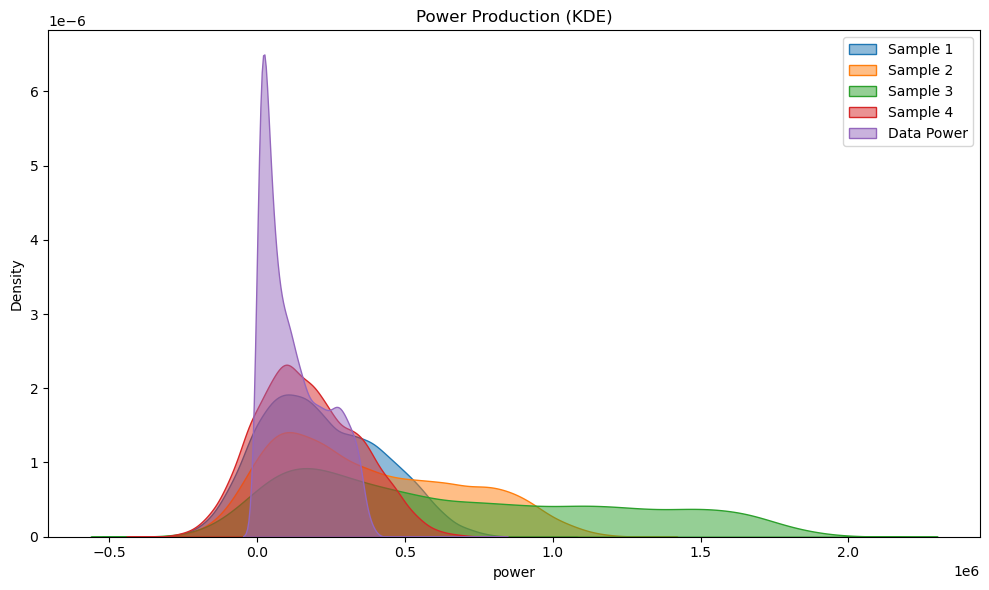

In [21]:
# Apply the simulate_joint function
np.random.seed(4)
n_samples = 4
result_ = simulate_joint(data['irradiance'], data['sun_azimuth'], data['sun_elevation'], num=n_samples)

power_production_samples = result_['power_production']
sigma_2_samples = result_['sigma_2']
eta_samples = result_['eta']
theta_p_samples = result_['theta_p']
phi_p_samples = result_['phi_p']

# Plot KDE for power production samples
fig, axes = plt.subplots(figsize=(10, 6))
for i in range(n_samples):
    sns.kdeplot(power_production_samples[i].flatten(), fill=True, alpha=0.5, label=f'Sample {i + 1}', ax=axes)

sns.kdeplot(data['power'], fill=True, alpha=0.5, label='Data Power', ax=axes)
axes.set_title('Power Production (KDE)')
axes.legend()

plt.tight_layout()
plt.show()

In [22]:
for i in range(n_samples):
    flattened_samples = power_production_samples[i].flatten()

    # Compute mean and standard deviation for each sample
    mean_value = np.mean(flattened_samples)
    std_dev_value = np.std(flattened_samples)

    print(f"\nSample {i + 1}:")
    print("Mean:", mean_value)
    print("Standard Deviation:", std_dev_value)


Sample 1:
Mean: 217320.13042862568
Standard Deviation: 200348.49213570182

Sample 2:
Mean: 373666.4957363797
Standard Deviation: 311342.6967542238

Sample 3:
Mean: 675968.558177166
Standard Deviation: 539330.6730551252

Sample 4:
Mean: 169948.77290890343
Standard Deviation: 170477.60752727507


In [23]:
# Mean and standard deviation of raw's data of power production
print("Mean:",data['power'].mean())
print("Standard deviation:",data['power'].std())

Mean: 126408.36503610846
Standard deviation: 105415.97153215708


Through the prior predictive check of $P_{1:T}$, the mean and standard deviation of the simulated power production are around those of the true power production. Moreover the obtained value densities are more concentrated between $0.1 \cdot 10^7$ and $0.25 \cdot 10^7$, and the maximum value of a density is around of $10^{-6}$.

<div class="alert alert-success">
    
**Exercise**. Write a `log_posterior` function that returns the logarithm of the (unormalized) probability density function $p(\sigma^2, \eta, \theta^p, \phi^p | P_{1:T}, F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T})$ using the previously defined priors.
    
</div>

We have : $$
p(\sigma^2, \eta, \theta^p, \phi^p |P_{1:T},  F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}) = \frac{ p(\sigma^2) \cdot p(\eta) \cdot p(\theta^p) \cdot p(\phi^p) \cdot p(P_{1:T},  F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T} | \sigma^2, \eta, \theta^p, \phi^p)}{p(P_{1:T},  F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T})}
$$
Thus :

$$\log(p(\sigma^2, \eta, \theta^p, \phi^p |P_{1:T},  F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T}))$$  $\propto$ $$\log(p(\sigma^2) + \log(\theta^p) + \log(\phi^p) + \log(\eta) + \log(p(P_{1:T},  F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T} | \sigma^2, \eta, \theta^p, \phi^p)$$

In [24]:
from scipy.stats import gamma, uniform, norm

theta_true = [ 0.14, -np.pi, 2.99, data['power'].var()]
def log_prior(theta):
    return (
        uniform.logpdf(theta[0], loc=0, scale=1) +
        norm.logpdf(theta[1], loc=0, scale=2 * np.pi) +
        norm.logpdf(theta[2], loc=np.pi / 2, scale=1e-2) +
        gamma.logpdf(theta[3], a=data['power'].var(), scale=1)
    )

def log_posterior(theta, F_t, theta_s, phi_s, P_t):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood(theta, F_t, theta_s, phi_s, P_t) + log_prior(theta)

<div class="alert alert-success">
    
**Exercise**. Use MCMC to sample from the posterior probability density function $p(\sigma^2, \eta, \theta^p, \phi^p | P_{1:T}, F_{1:T}, \theta^s_{1:T}, \phi^s_{1:T})$.
    
</div>

In [25]:
nwalkers, ndim = 30, len(initial_params)
pos = result.x + 0.01 * np.random.randn(nwalkers, ndim)

In [26]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data['irradiance'],data['sun_azimuth'],data['sun_elevation'],data['power']))
sampler.run_mcmc(pos,5000,progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:54<00:00, 14.09it/s]


The choice of initial parameters is not insignificant. In order to achieve faster convergence, I have chosen, for example, for $\sigma^2$ the empirical variance estimate $\hat{\sigma}^2 = \frac{1}{T-1} \sum_{t=1}^{T} (P_t - \bar{P_t})^2$, for $\eta$ I chose $\hat{\eta} = \frac{\sum_{t=1}^{T} P_t}{A \cdot \sum_{t=1}^{T} F_t}$ and for $\hat{\phi_p}$ esitmate from the MLE.





<div class="alert alert-success">
    
**Exercise**. Plot the resulting Markov chains and discuss their mixing, agreement, and autocorrelation. Take the necessary measures to produce a good approximation of the posterior distribution.
    
</div>

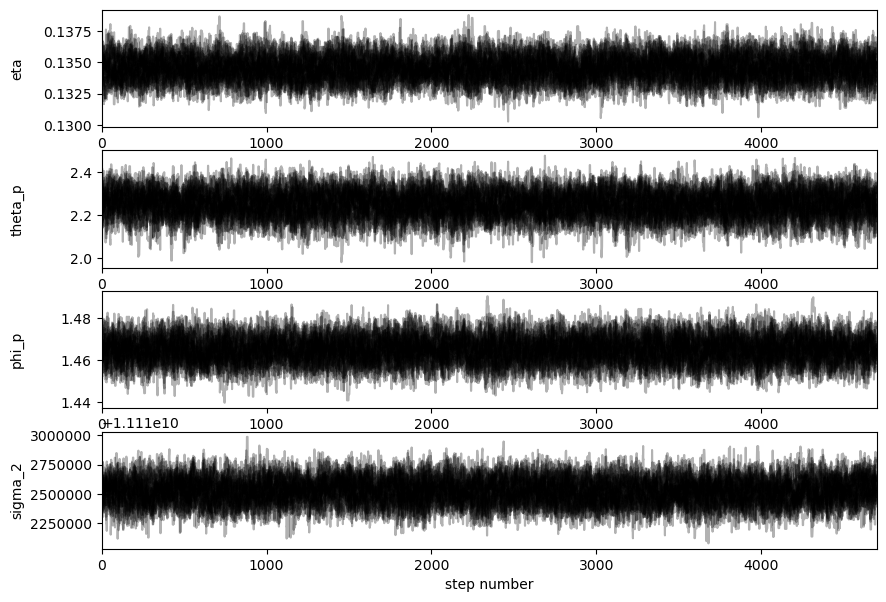

In [27]:
labels = ["eta", "theta_p", "phi_p", "sigma_2"]

fig, axes = plt.subplots(4, figsize=(10, 7))
thetas = sampler.get_chain(discard=300)

for i in range(4):
    ax = axes[i]
    ax.plot(thetas[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(thetas))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid(False)

axes[-1].set_xlabel("step number")
plt.show()

We note that the estimated values of the model parameter all cover a precise interval over the iterations: $\eta$, $\theta_p$, $\phi_p$,$\sigma^2$ $\in$ ]0.12;-0.14[ x ]8.25;9[ x x ]1.35;1.47[ x]225 . $10^{10}$;300 . $10^{10}$[ (parameter $\rho$ only for the model 2). The chains are stabilized and this means that the chains have sufficiently explored and converged to the posterior distribution of the parameters. We can visualize that through the trace plots of the chain samples. The autocorrelation times are relatively high, since the chains have slower convergence. Hence the mixing is good.

<div class="alert alert-success">
    
**Exercise**. Plot the estimated posterior probability distribution of the parameters and discuss these results.
    
</div>

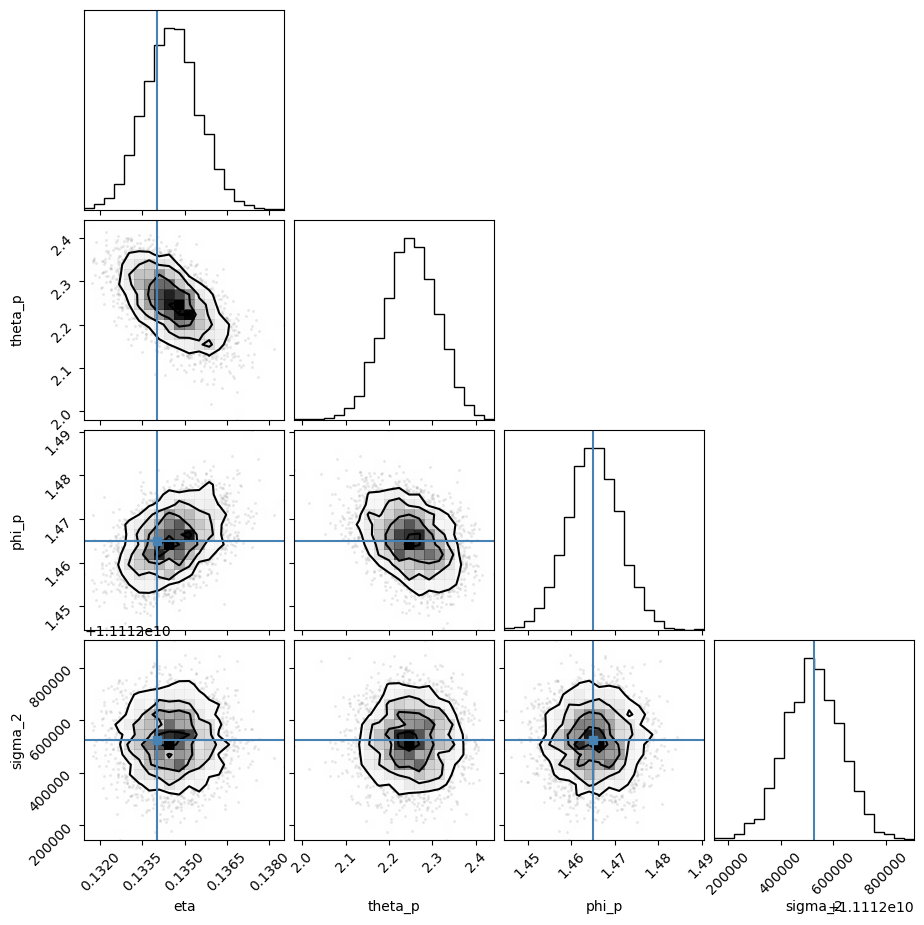

In [28]:
import corner
theta_true = [0.134, -4., 1.465,  data['power'].var()]
thetas = sampler.get_chain(flat=True, discard=300, thin=45)
fig = corner.corner(thetas, labels=labels, truths=theta_true)
fig

In [29]:
tau = sampler.get_autocorr_time()
tau

array([42.91449195, 46.58712483, 42.18216613, 44.0248771 ])

we obtain the following outcomes: 

- The diagonal plots display histograms of each parameter in the chain and the off-diagonal plots display scatter plots between pairs of parameters.

- The mode of the histogram of parameter $\eta$ is in the interval [0.133;0.134], that of $\theta_p$ is in [8.4; 8.64] , that of $\phi_p$ is in [1.46;1.47[. In addition, the darkest regions represent the highest probability densities for each pair of parameters of our models. That helps us to overlay better the true parameters in these regions.


<div class="alert alert-success">
    
**Exercise**. Plot the posterior predictive distribution of the photovoltaic production model compare it to the observed power production $P_{1:T}$.
        
</div>

In [30]:
from sklearn.metrics import mean_squared_error

# Define the pp1 function
def pp(F_t, theta_s, phi_s, P_t, num, thetas):
    
    permuted_indices = np.random.permutation(len(thetas))[:num]
    eta_post = thetas[permuted_indices, 0]
    theta_p_post = thetas[permuted_indices, 1]
    phi_p_post = thetas[permuted_indices, 2]
    sigma_2_post = thetas[permuted_indices, 3]

    power_production_samples = []
    biases = []  # To store biases for each sample set
    for i in range(num):
        samples_i = []
        for j in range(len(F_t)):
            power_sample_t = simulate(F_t[j], theta_s[j], phi_s[j], [eta_post[i], theta_p_post[i], phi_p_post[i], sigma_2_post[i]])
            samples_i.append(power_sample_t)
        power_production_samples.append(samples_i)
        bias = mean_squared_error(np.array(samples_i) , np.array(P_t))  # Calculate bias
        biases.append(bias)

    return power_production_samples, biases

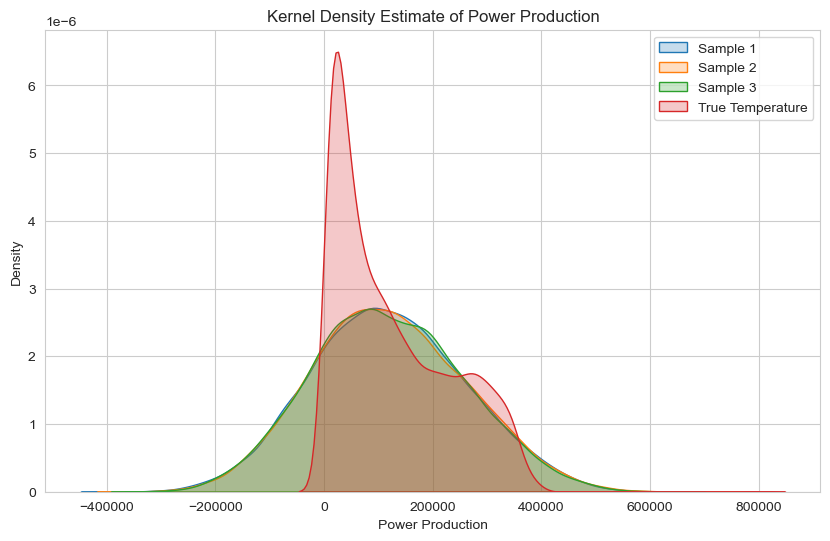

In [33]:
num = 3
F_t = data['irradiance'].values
theta_s = data['sun_azimuth'].values
phi_s = data['sun_elevation'].values
P_t = data['power'].values


power_production_samples, biases = pp(F_t, theta_s, phi_s, P_t, num, thetas)

sns.set_style("whitegrid")
# Plot the KDE for each set of samples and display corresponding biases
plt.figure(figsize=(10, 6))
for i in range(num):
    sns.kdeplot(np.array(power_production_samples[i]).flatten(), label=f'Sample {i+1}', fill=True)
sns.kdeplot(data['power'], label='True Temperature', fill=True)
plt.xlabel('Power Production')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Power Production')
plt.legend()
plt.show()

In [32]:
for i in range(3):
    print(f'Sample {i}', biases[i])

Sample 0 14964627407.872786
Sample 1 14720208435.971603
Sample 2 15003964884.97471


The MSE we calculate represents the $bias^2$ ; the higher it is, the poorer the model. It is obvious that the posterior predictive distribution of the second photovoltaic production model, fits better than the others, with the true power production.